<a href="https://colab.research.google.com/github/007G/notebooks/blob/main/GradCam_check_harness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-deguda71
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-deguda71
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 51ae19245f655cf0ee334db2a945ceb1a4d6df59
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ttach-0.0.3-py3-none-any.whl (9.8 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py

In [2]:
import copy
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import re, os, sys, json, cv2, random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import numpy as np
#from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
import seaborn as sns


import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import os
import random
from glob import glob
# Pytorch
from torchvision import datasets, models, transforms
from torch.nn import functional as F

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
#from torchinfo import summary

In [4]:
# Load the ResNet50 model pre-trained on ImageNet
model = models.resnet18(pretrained=True)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


In [5]:
for name, param in model.named_parameters():
    print(f"{name}: Requires Grad - {param.requires_grad}")

freeze_until_layer = 'layer4'
freeze_next_layers = True


for name, param in model.named_parameters():
    if freeze_until_layer in name:
        freeze_next_layers = False

    if freeze_next_layers:
        param.requires_grad = False
    else:
        param.requires_grad = True

print("\n\n#####################Model Afrer Freeze ########################")
for name, param in model.named_parameters():
    print(f"{name}: Requires Grad - {param.requires_grad}")

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs,2)

print(model)


conv1.weight: Requires Grad - True
bn1.weight: Requires Grad - True
bn1.bias: Requires Grad - True
layer1.0.conv1.weight: Requires Grad - True
layer1.0.bn1.weight: Requires Grad - True
layer1.0.bn1.bias: Requires Grad - True
layer1.0.conv2.weight: Requires Grad - True
layer1.0.bn2.weight: Requires Grad - True
layer1.0.bn2.bias: Requires Grad - True
layer1.1.conv1.weight: Requires Grad - True
layer1.1.bn1.weight: Requires Grad - True
layer1.1.bn1.bias: Requires Grad - True
layer1.1.conv2.weight: Requires Grad - True
layer1.1.bn2.weight: Requires Grad - True
layer1.1.bn2.bias: Requires Grad - True
layer2.0.conv1.weight: Requires Grad - True
layer2.0.bn1.weight: Requires Grad - True
layer2.0.bn1.bias: Requires Grad - True
layer2.0.conv2.weight: Requires Grad - True
layer2.0.bn2.weight: Requires Grad - True
layer2.0.bn2.bias: Requires Grad - True
layer2.0.downsample.0.weight: Requires Grad - True
layer2.0.downsample.1.weight: Requires Grad - True
layer2.0.downsample.1.bias: Requires Grad -

In [6]:
# Pick up layers for visualization
target_layers = [model.layer4[-1]]

In [7]:
print(target_layers)

[BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


In [8]:
path = "/content/shar2.png"

rgb_img = Image.open(path).convert('RGB')
# Max min normalization
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
# Create an input tensor image for your model
input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
print(input_tensor)
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
print(cam)
print(target_layers)
# cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=False)
# cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
# targets = [e.g ClassifierOutputTarget(281)]
# target_category = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor)
print(grayscale_cam)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

tensor([[[[0.6235, 0.5922, 0.6275,  ..., 0.5922, 0.4627, 0.4706],
          [0.5804, 0.6706, 0.6941,  ..., 0.4000, 0.3608, 0.4667],
          [0.7529, 0.6941, 0.5843,  ..., 0.3451, 0.3608, 0.4039],
          ...,
          [0.4510, 0.4667, 0.4745,  ..., 0.4353, 0.4353, 0.4392],
          [0.4667, 0.4588, 0.4431,  ..., 0.4353, 0.4392, 0.4392],
          [0.4588, 0.4510, 0.4353,  ..., 0.4392, 0.4392, 0.4392]],

         [[0.6275, 0.5961, 0.6314,  ..., 0.5373, 0.4078, 0.4157],
          [0.5882, 0.6784, 0.7020,  ..., 0.3490, 0.3098, 0.4157],
          [0.7608, 0.7020, 0.5922,  ..., 0.2980, 0.3137, 0.3569],
          ...,
          [0.4314, 0.4471, 0.4549,  ..., 0.4235, 0.4235, 0.4275],
          [0.4471, 0.4392, 0.4235,  ..., 0.4235, 0.4275, 0.4275],
          [0.4431, 0.4353, 0.4196,  ..., 0.4314, 0.4314, 0.4314]],

         [[0.6118, 0.5804, 0.6157,  ..., 0.5059, 0.3765, 0.3843],
          [0.5725, 0.6627, 0.6863,  ..., 0.3176, 0.2784, 0.3843],
          [0.7451, 0.6863, 0.5765,  ..., 0

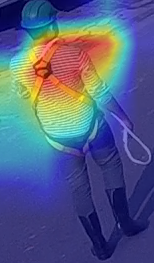

In [9]:
Image.fromarray(visualization, 'RGB')


In [19]:
#model = models.resnet18(pretrained=False)
#for param in model.parameters():
 #       param.requires_grad = False
#num_ftrs = model.fc.in_features#
#model.fc = nn.Linear(num_ftrs,2)

model.load_state_dict(torch.load('/content/resnet_20240318_harness_no_harness.pth'))
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Pick up layers for visualization
target_layers = [model.layer4[-1]]

In [21]:
print(target_layers)

[BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)]


In [25]:
path = "/content/shar1.png"

rgb_img = Image.open(path).convert('RGB')
# Max min normalization
rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))
# Create an input tensor image for your model
input_tensor = torchvision.transforms.functional.to_tensor(rgb_img).unsqueeze(0).float()
print(input_tensor)
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers)
print(cam)
# cam = GradCAMPlusPlus(model=model, target_layers=target_layers, use_cuda=False)
# cam = ScoreCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
# targets = [e.g ClassifierOutputTarget(281)]
# target_category = None

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor)
print()

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

tensor([[[[0.8196, 0.8118, 0.7961,  ..., 0.6118, 0.6118, 0.6039],
          [0.8000, 0.8039, 0.7765,  ..., 0.6118, 0.6118, 0.6039],
          [0.8000, 0.7686, 0.7804,  ..., 0.6196, 0.6118, 0.6039],
          ...,
          [0.5059, 0.5137, 0.4863,  ..., 0.5255, 0.5255, 0.5216],
          [0.5098, 0.4980, 0.4980,  ..., 0.5294, 0.5294, 0.5176],
          [0.5216, 0.5020, 0.5255,  ..., 0.5333, 0.5216, 0.5098]],

         [[0.7608, 0.7451, 0.7294,  ..., 0.5843, 0.5843, 0.5882],
          [0.7451, 0.7333, 0.7059,  ..., 0.5843, 0.5843, 0.5882],
          [0.7490, 0.7098, 0.7216,  ..., 0.5922, 0.5843, 0.5843],
          ...,
          [0.4863, 0.4941, 0.4667,  ..., 0.5059, 0.5059, 0.5020],
          [0.4902, 0.4784, 0.4784,  ..., 0.5098, 0.5098, 0.4980],
          [0.5020, 0.4824, 0.5059,  ..., 0.5137, 0.5020, 0.4902]],

         [[0.7216, 0.6980, 0.6824,  ..., 0.5686, 0.5686, 0.5686],
          [0.7137, 0.6902, 0.6627,  ..., 0.5686, 0.5686, 0.5686],
          [0.7176, 0.6667, 0.6784,  ..., 0

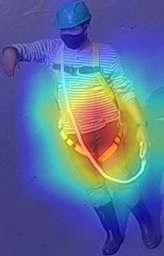

In [26]:
Image.fromarray(visualization, 'RGB')